In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec


In [3]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [4]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

# Loading variables

In [6]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


CPU times: user 9.01 s, sys: 6.43 s, total: 15.4 s
Wall time: 52.7 s


# Correct resolutions

In [7]:
dx=500 #resolution in meters
dy=500

In [8]:
Temp_no_units=tf[0].drop(['nav_lat_rho','nav_lon_rho'])

# x_b=tf.x_rho
# y_b=tf.y_rho

Temp_with_units=Temp_no_units.assign_coords(
    x_rho=(['x_rho'],tf.x_rho.data*dx)
    ).assign_coords(
    y_rho=(['y_rho'],tf.y_rho.data*dy))

In [9]:
T_spec_pyspec=spec.TWODimensional_spec(Temp_no_units,dx,dy,detrend=True)

In [10]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'
# scl='spectrum'


T_spec_xrft_no_units=xrft.isotropic_power_spectrum(Temp_no_units,
                                  dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

T_spec_xrft_with_units=xrft.isotropic_power_spectrum(Temp_with_units,
                                  dim=['y_rho','x_rho'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

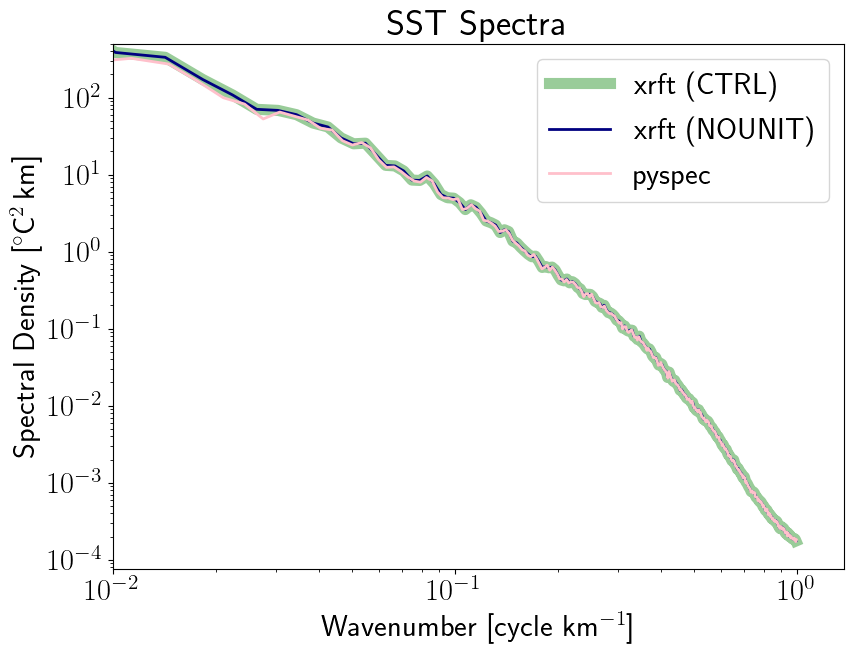

In [24]:
plt.figure(figsize=(9,7))


plt.plot(T_spec_xrft_with_units.freq_r*1e3,T_spec_xrft_with_units,
         label='xrft (CTRL)',linewidth=8,color='green',alpha=0.4)

plt.plot((T_spec_xrft_no_units.freq_r/dx)*1e3,T_spec_xrft_no_units*(dx),
         label='xrft (NOUNIT)',linewidth=2,color='navy')

plt.plot(T_spec_pyspec.ki*1e3,T_spec_pyspec.ispec/(2*np.pi),
         label='pyspec',linewidth=2,color='pink')

plt.legend()

plt.yscale('log')
plt.xscale('log')


plt.title('SST Spectra')
plt.xlabel(r'Wavenumber [cycle km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [$^{\circ}$C$^{2}$\,km]\,',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(0,500)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

# For Energy

In [12]:
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,100:-100,100:-200],vf[:,100:-100,100:-200]

In [13]:
U_no_units=uf[0]
V_no_units=vf[0]

U_with_units=U_no_units.assign_coords(
    x_u=(['x_u'],uf.x_u.data*dx)
    ).assign_coords(
    y_u=(['y_u'],uf.y_u.data*dy))


V_with_units=V_no_units.assign_coords(
    x_v=(['x_v'],vf.x_v.data*dx)
    ).assign_coords(
    y_v=(['y_v'],vf.y_v.data*dy))




In [14]:
U_spec_pyspec=spec.TWODimensional_spec(U_no_units,dx,dy,detrend=True)
V_spec_pyspec=spec.TWODimensional_spec(V_no_units,dx,dy,detrend=True)

EKE_spec_pyspec=.5*(U_spec_pyspec.ispec+V_spec_pyspec.ispec)
EKE_ki=U_spec_pyspec.ki

In [53]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'
# scl='spectrum'
rr={'true_phase':True,'true_amplitude':True}


U_spec_xrft_no_units=xrft.isotropic_power_spectrum(U_no_units,
                                  dim=['y_u','x_u'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor,**rr)

U_spec_xrft_with_units=xrft.isotropic_power_spectrum(U_with_units,
                                  dim=['y_u','x_u'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor,**rr)


V_spec_xrft_no_units=xrft.isotropic_power_spectrum(V_no_units,
                                  dim=['y_v','x_v'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor,**rr)

V_spec_xrft_with_units=xrft.isotropic_power_spectrum(V_with_units,
                                  dim=['y_v','x_v'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor,**rr)


EKE_spec_xrft_no_units=.5*(U_spec_xrft_no_units + V_spec_xrft_no_units)
EKE_spec_xrft_with_units=.5*(U_spec_xrft_with_units + V_spec_xrft_with_units)


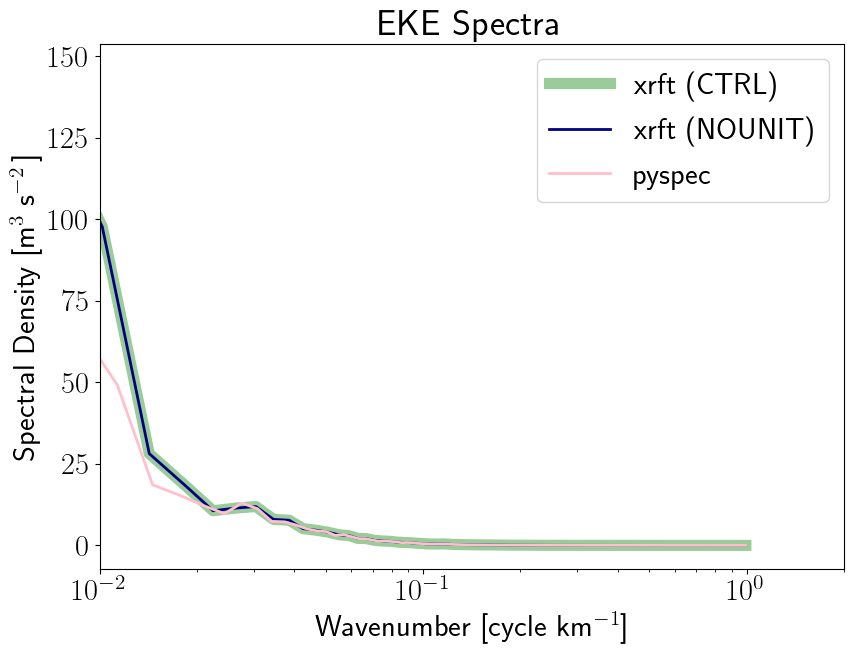

In [345]:
plt.figure(figsize=(9,7))


plt.plot(EKE_spec_xrft_with_units.freq_r*1e3,EKE_spec_xrft_with_units,
         label='xrft (CTRL)',linewidth=8,color='green',alpha=0.4)

plt.plot((EKE_spec_xrft_no_units.freq_r/dx)*1e3,EKE_spec_xrft_no_units*(dx),
         label='xrft (NOUNIT)',linewidth=2,color='navy')

plt.plot(EKE_ki*1e3,EKE_spec_pyspec/(2*np.pi),
         label='pyspec',linewidth=2,color='pink')


plt.legend()

# plt.yscale('log')
plt.xscale('log')


plt.title('EKE Spectra')
plt.xlabel(r'Wavenumber [cycle km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$ s$^{-2}$\,]',fontweight='bold')

plt.xlim(1/100,1/0.5)
# plt.ylim(0,500)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

## What about 1D spectra ?

<Figure size 640x480 with 0 Axes>

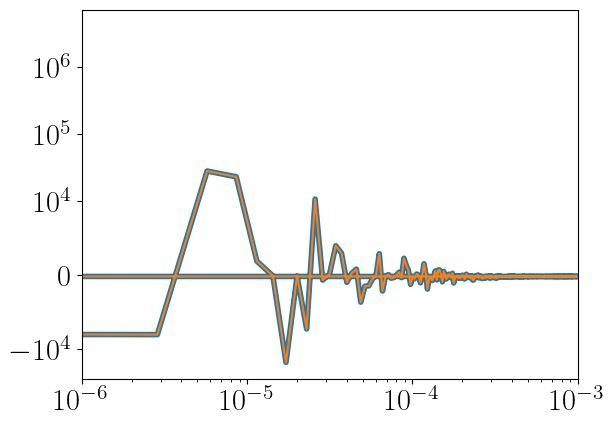

<Figure size 640x480 with 0 Axes>

In [319]:
dn=500
B0=np.fft.fft(Temp_with_units[600,:],n=Temp_with_units[600,:].shape[0])
B0k=np.fft.fftfreq(Temp_with_units[600,:].shape[0],d=dn)
B1=xrft.fft(Temp_with_units[600,:],shift=False)


plt.figure()
plt.plot(B0k,B0*dn,linewidth=4)
plt.plot(B1.freq_x_rho,B1)
plt.yscale('symlog',linthresh=1e4)
plt.xscale('log')
# plt.ylim(-1e4,1e4)
plt.xlim(1e-6,1e-3)


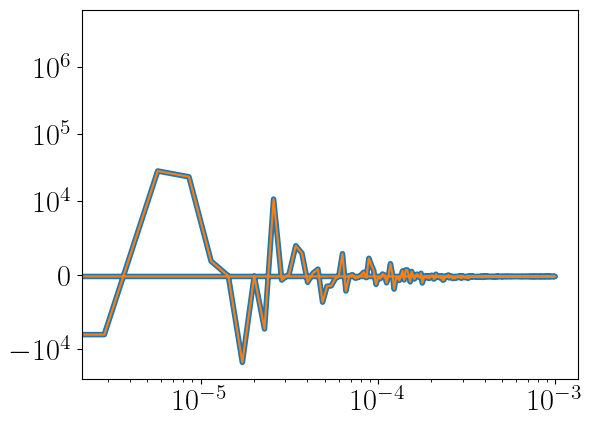

In [346]:
B0=np.fft.fft(Temp_no_units[600,:],n=Temp_no_units[600,:].shape[0])
B0k=np.fft.fftfreq(Temp_no_units[600,:].shape[0],d=dn)
B1=xrft.fft(Temp_no_units[600,:],shift=False)


plt.figure()

plt.plot(B0k.real,(B0)*dn,linewidth=4)
plt.plot(B1.freq_x_rho.real/dn,(B1)*dn)
plt.yscale('symlog',linthresh=1e4)
plt.xscale('log')
# plt.ylim(-1000,1000)
# plt.xlim(1e-6,1e-3)

# Conclusion

## Pyspec
#### Uses window correction and spectral density;
#### Hanning window is used
#### Easy to compute different dx's

## xrft
#### correction is /dxx for both frequency and spectrum
#### Different window choice changes the value